# **Import dependencies**

In [1]:
# from datetime import timedelta as td
import os
import warnings as wn

import numpy as np
import pandas as pd
from floris.utilities import wrap_360
from matplotlib import pyplot as plt

from flasc.data_processing import (
    dataframe_filtering as dff,
    dataframe_manipulations as dfm,
    energy_ratio_wd_bias_estimation as best,
    northing_offset as nof,
)

# from flasc import time_operations as fto
from flasc.utilities import (
    floris_tools as ftools,
    optimization as flopt,
)
from flasc.utilities.utilities_examples import load_floris_artificial as load_floris

In [2]:
# User settings
save_figures = True
plot_figures_in_notebook = True

# **Step 0**: Initial data pulldown
First, we import the data from the common_windfarm_information folder. This may take a while, so we keep these variables unchanged. These are df_scada_raw and df_metmast_raw. These variables are not manipulated throughout the script.

In [3]:
def load_data():
    root_path = os.getcwd()
    f = os.path.join(root_path, "postprocessed", "df_scada_600s_wspowfiltered.ftr")
    df_scada = pd.read_feather(f)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada


df_scada_northing_uncalibrated = load_data()
df_scada_northing_uncalibrated["ti"] = 0.06  # Assume a certain ambient turbulence intensity

# **Step 1**: Initialize FLORIS
and precalculate a large set of solutions using the parallel computing interface in FLORIS

In [4]:
# Now we calculate a grid of FLORIS solutions. Since our estimated SCADA
# data changes as we shift its wind direction, the predicted solutions
# according to FLORIS will also change. Therefore, we precalculate a grid
# of FLORIS solutions and insert that into the bias estimation class.
fm, turbine_weights = load_floris()

# Grab the precalculated FLORIS model solutions from the 'setup_floris_model' directory
root_path = os.getcwd()
fn_approx = os.path.join(root_path, "..", "00_setup_floris_model", "df_fi_approx_gch.ftr")
if os.path.exists(fn_approx):
    df_fm_approx = pd.read_feather(fn_approx)
else:
    raise UserWarning(
        "Please run '00_setup_floris_model/03_precalculate_floris_solutions.py' "
        "for the appropriate wake models first."
    )

# **Step 2**: Cross-compare wind direction measurements
and see if the relative offset between turbines is consistent. If the offset is consistent, then we know we can find a single offset value that would align the two turbine's northings. If this is not the case, one or both turbines likely experience jumps in their nacelle calibration throughout the timeseries. The current functionality is limited and cannot account for this yet.

Matching curves for turbine 000...
   T006  T001  T002  T005  T003
0  18.0  16.0  -6.0  14.0  46.0
1  18.0  16.0  -6.0  14.0  46.0
2  18.0  16.0  -6.0  14.0  46.0
3  18.0  14.0  -6.0  14.0  46.0
Matching curves for turbine 001...
   T002  T006  T005  T003  T000
0 -22.0   2.0  -2.0  30.0 -16.0
1 -20.0   2.0  -2.0  30.0 -16.0
2 -20.0   2.0  -2.0  30.0 -16.0
3 -22.0   2.0  -2.0  30.0 -14.0
Matching curves for turbine 002...
   T001  T003  T005  T000  T006
0  22.0  52.0  20.0   6.0  24.0
1  20.0  52.0  20.0   6.0  24.0
2  20.0  52.0  20.0   6.0  24.0
3  22.0  52.0  20.0   6.0  24.0
Matching curves for turbine 003...
   T005  T002  T001  T004  T006
0 -32.0 -52.0 -30.0 -30.0 -28.0
1 -32.0 -52.0 -30.0 -30.0 -28.0
2 -32.0 -52.0 -30.0 -30.0 -28.0
3 -32.0 -52.0 -30.0 -30.0 -28.0
Matching curves for turbine 004...
   T003  T002  T005  T001  T006
0  30.0 -22.0  -2.0  -2.0   2.0
1  30.0 -22.0  -2.0  -2.0   2.0
2  30.0 -22.0  -2.0  -2.0   2.0
3  30.0 -22.0  -2.0  -2.0   2.0
Matching curves for turbi

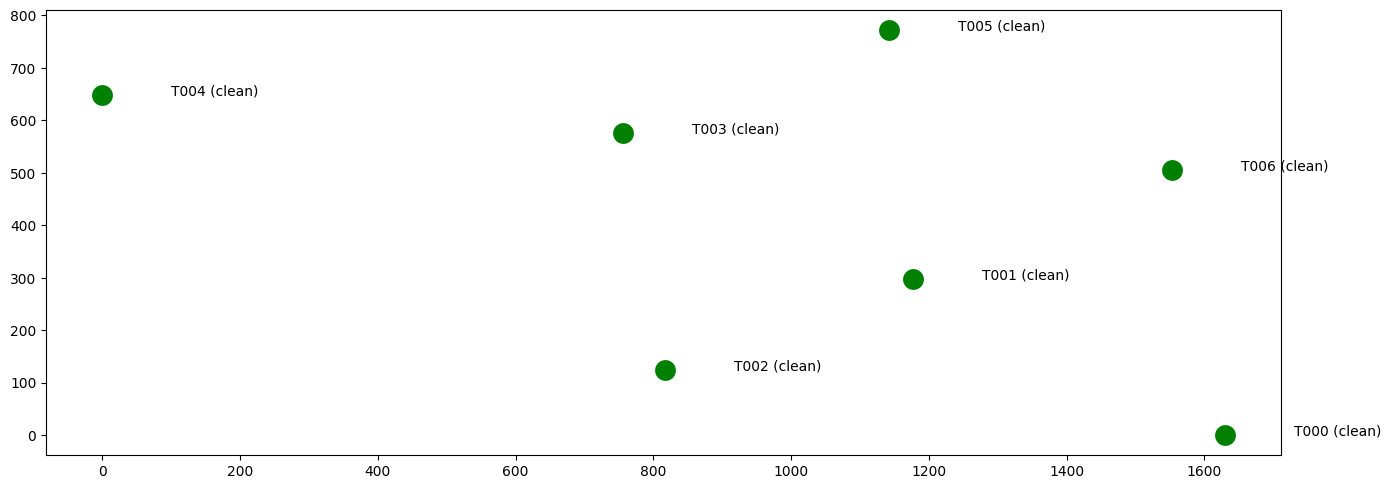

In [5]:
# Create a copy in which we mark the wd measurements of turbines with northing drift  as faulty
df_scada_marked_faulty_northing_drift = df_scada_northing_uncalibrated.copy()

turb_wd_consistency = nof.crosscheck_northing_offset_consistency(
    df=df_scada_marked_faulty_northing_drift, fm=fm, plot_figure=True
)
print(turb_wd_consistency)

# Mark wind direction measurements of turbines with inconsistent calibration as faulty
faulty_turbines = [not s == "clean" for s in turb_wd_consistency]
for ti in np.where(faulty_turbines)[0]:
    df_scada_marked_faulty_northing_drift["wd_{:03d}".format(ti)] = np.nan

# **Step 3**: Estimate the wind direction bias for a single wind turbine
By looking at the energy ratios and looking at the average offset between turbines' wind direction measurements, we can align every turbine that was flagged 'green' in the above plot with true north. Wind directions of turbines flagged red should not be used.

Initializing wd bias estimator object for turbine 000...
2024-04-08 10:47:04: Initializing a bias_estimation() object...
2024-04-08 10:47:04: Estimating the wind direction bias
2024-04-08 10:47:04:     Initializing energy ratio inputs.
2024-04-08 10:47:04:   Constructing energy table for wd_bias of -180.00 deg.
2024-04-08 10:47:04:     Interpolating FLORIS predictions for dataframe.
   minimum/maximum value in df:        (0.000, 26.405)
   minimum/maximum value in df_approx: (1.000, 30.000)
2024-04-08 10:47:04:     Determining energy ratios for test turbine = 006. WD bias: -180.000 deg.
2024-04-08 10:47:05:     Determining energy ratios for test turbine = 001. WD bias: -180.000 deg.
2024-04-08 10:47:05:     Determining energy ratios for test turbine = 002. WD bias: -180.000 deg.
2024-04-08 10:47:05:     Initializing energy ratio inputs.
2024-04-08 10:47:05:   Constructing energy table for wd_bias of -175.00 deg.
2024-04-08 10:47:05:     Interpolating FLORIS predictions for dataframe.
 

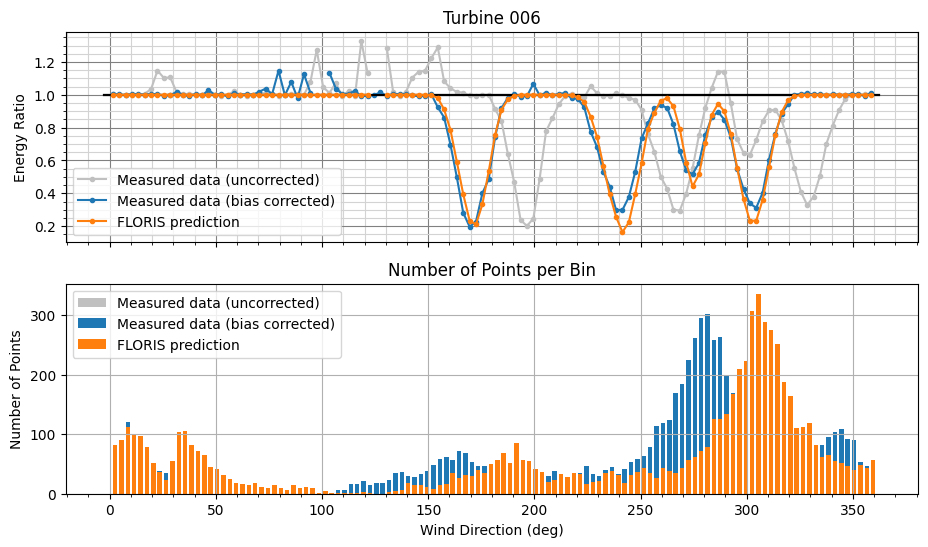

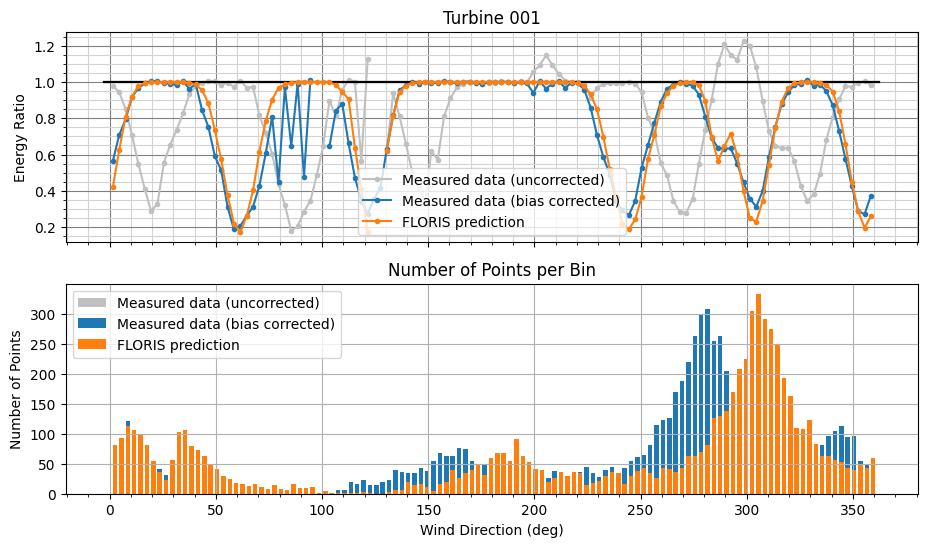

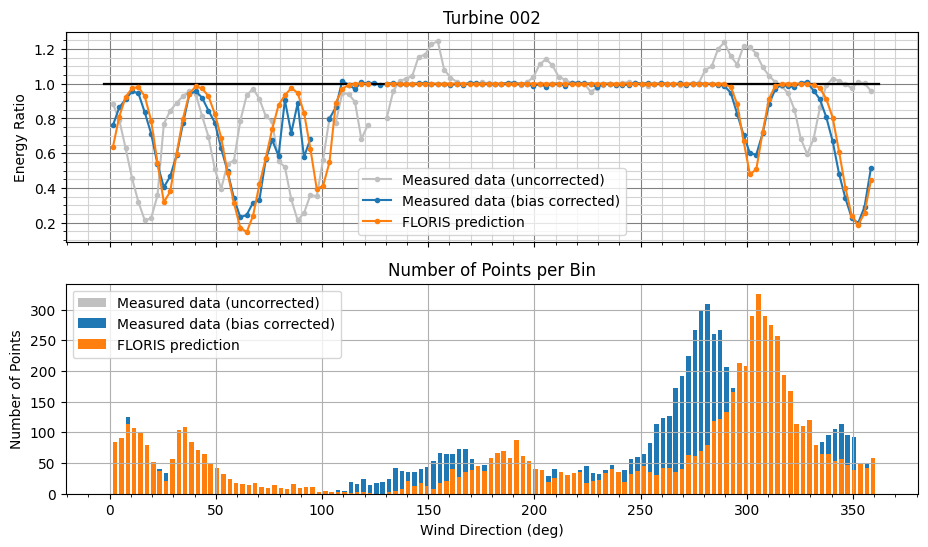

In [6]:
def get_bias_for_single_turbine(
    df, fm, ti, opt_search_range=[-180.0, 180.0], plot=True, figure_save_path=None
):
    print("Initializing wd bias estimator object for turbine %03d..." % ti)

    # Copy variables and unlink them
    df = df.copy()  # Unlink from input

    # Calculate which turbines are upstream for every wind direction
    df_upstream = ftools.get_upstream_turbs_floris(fm, wd_step=2.0)

    # We assign the total datasets "true" wind direction as equal to the wind
    # direction of the turbine which we want to perform northing calibration
    # on. In this case, turbine 'ti'.
    df = dfm.set_wd_by_turbines(df, [ti])

    # We define a function that calculates the freestream wind speed based
    # on a dataframe that is inserted. It does this based on knowing which
    # turbines are upstream for what wind directions, and then knowledge
    # of what the wind direction is for every row in the dataframe. However,
    # since the shift the "true" wind direction many times to estimate the
    # northing bias, we cannot precalculate this. It changes with every
    # northing bias guess. Hence, we must insert a function.
    def _set_ws_fun(df):
        return dfm.set_ws_by_upstream_turbines_in_radius(
            df=df,
            df_upstream=df_upstream,
            turb_no=ti,
            x_turbs=fm.layout_x,
            y_turbs=fm.layout_y,
            max_radius=5000.0,
            include_itself=True,
        )

    # We similarly define a function that calculates the reference power. This
    # is typically the power production of one or multiple upstream turbines.
    # Here, we assume it is the average power production of all upstream
    # turbines. Which turbines are upstream depends on the wind direction.
    def _set_pow_ref_fun(df):
        return dfm.set_pow_ref_by_upstream_turbines_in_radius(
            df=df,
            df_upstream=df_upstream,
            turb_no=ti,
            x_turbs=fm.layout_x,
            y_turbs=fm.layout_y,
            max_radius=5000.0,
            include_itself=True,
        )

    # Now we calculate a grid of FLORIS solutions. Since our estimated SCADA
    # data changes as we shift its wind direction, the predicted solutions
    # according to FLORIS will also change. Therefore, we precalculate a grid
    # of FLORIS solutions and insert that into the bias estimation class.
    df_approx = pd.read_feather(fn_approx)

    # We now have the reference power productions specified, being equal to
    # the mean power production of all turbines upstream. We also need to
    # define a test power production, which should be waked at least part of
    # the time so that we can match it with our FLORIS predictions. Here, we
    # calculate the energy ratios for the 3 turbines closest to the turbine
    # from which we take the wind direction measurement ('ti').
    turbines_sorted_by_distance = ftools.get_turbs_in_radius(
        x_turbs=fm.layout_x,
        y_turbs=fm.layout_y,
        turb_no=ti,
        max_radius=1.0e9,
        include_itself=False,
        sort_by_distance=True,
    )
    test_turbines = turbines_sorted_by_distance[0:3]

    # Now, we have all information set up and we can initialize the northing
    # bias estimation class.
    fsc = best.bias_estimation(
        df=df,
        df_fm_approx=df_approx,
        test_turbines_subset=test_turbines,
        df_ws_mapping_func=_set_ws_fun,
        df_pow_ref_mapping_func=_set_pow_ref_fun,
    )

    # We can save the energy ratio curves for every iteration in the
    # optimization process. This is useful for debugging. However, it also
    # significantly slows down the estimation process. We disable it by
    # default by assigning it 'None'.
    plot_iter_path = None  # Disabled, useful for debugging but slow
    # plot_iter_path = os.path.join(out_path, "opt_iters_ti%03d" % ti)

    # Now estimate the wind direction bias while catching warning messages
    # that do not really inform but do pollute the console.
    with wn.catch_warnings():
        wn.filterwarnings(action="ignore", message="All-NaN slice encountered")

        # Estimate bias for the entire time range, from start to end of
        # dataframe, for wind speeds in region II of turbine operation, with
        # in steps of 3.0 deg (wd) and 5.0 m/s (ws). We search over the entire
        # range from -180.0 deg to +180.0 deg, in steps of 5.0 deg. This has
        # appeared to be a good stepsize empirically.
        wd_bias, _ = fsc.estimate_wd_bias(
            time_mask=None,  # For entire dataset
            ws_mask=(6.0, 10.0),
            er_wd_step=3.0,
            er_ws_step=5.0,
            er_wd_bin_width=3.0,
            er_N_btstrp=1,
            opt_search_brute_dx=5.0,
            opt_search_range=opt_search_range,
            plot_iter_path=plot_iter_path,
        )
        wd_bias = float(wd_bias[0])  # Convert to float

    # Print progress to console
    print("Turbine {}. estimated bias = {} deg.".format(ti, wd_bias))

    if plot:
        # Produce and save calibrated/corrected energy ratio figures
        fsc.plot_energy_ratios(show_uncorrected_data=True, save_path=figure_save_path)
        if figure_save_path is not None:
            print("Calibrated energy ratio figures saved to {:s}.".format(figure_save_path))

    # Finally, return the estimated wind direction bias
    return wd_bias


# We will calibrate the turbine nacelle heading for the first 'clean' turbine
first_clean_turbid = np.where([c == "clean" for c in turb_wd_consistency])[0][0]

# Calculate optimal bias for the first clean turbine, covering all possibilities
#  (from -180 deg to +180 deg offset)
wd_bias = get_bias_for_single_turbine(
    df=df_scada_marked_faulty_northing_drift,
    fm=fm,
    ti=first_clean_turbid,
    opt_search_range=(-180.0, 180.0),
    plot=True,
)
print("WD bias for first clean turbine: {:.3f} deg".format(wd_bias))

# Now calculate the northing-bias-corrected wind direction for this
#  turbine and call it our reference
wd_ref = wrap_360(
    df_scada_marked_faulty_northing_drift["wd_{:03d}".format(first_clean_turbid)] - wd_bias
)

# **Step 4**: Estimate the biases of the remaining turbines
Now that we know the wind direction bias of a single turbine, we roughly know where true north lies. What we can now do is simply calculate the average offset between the wind direction of any turbine and this northing-calibrated wind direction. The wind direction bias for that turbine is likely very close to this number. We use this as a first guess for the energy-ratio-based bias estimation, and optimize within +- 5 degrees within this initial value.

Initializing wd bias estimator object for turbine 000...
2024-04-08 10:48:20: Initializing a bias_estimation() object...
2024-04-08 10:48:20: Estimating the wind direction bias
2024-04-08 10:48:20:     Initializing energy ratio inputs.
2024-04-08 10:48:20:   Constructing energy table for wd_bias of 21.00 deg.
2024-04-08 10:48:20:     Interpolating FLORIS predictions for dataframe.
   minimum/maximum value in df:        (0.000, 26.430)
   minimum/maximum value in df_approx: (1.000, 30.000)
2024-04-08 10:48:21:     Determining energy ratios for test turbine = 006. WD bias: 21.000 deg.
2024-04-08 10:48:21:     Determining energy ratios for test turbine = 001. WD bias: 21.000 deg.
2024-04-08 10:48:21:     Determining energy ratios for test turbine = 002. WD bias: 21.000 deg.
2024-04-08 10:48:21:     Initializing energy ratio inputs.
2024-04-08 10:48:21:   Constructing energy table for wd_bias of 26.00 deg.
2024-04-08 10:48:21:     Interpolating FLORIS predictions for dataframe.
   minimum/

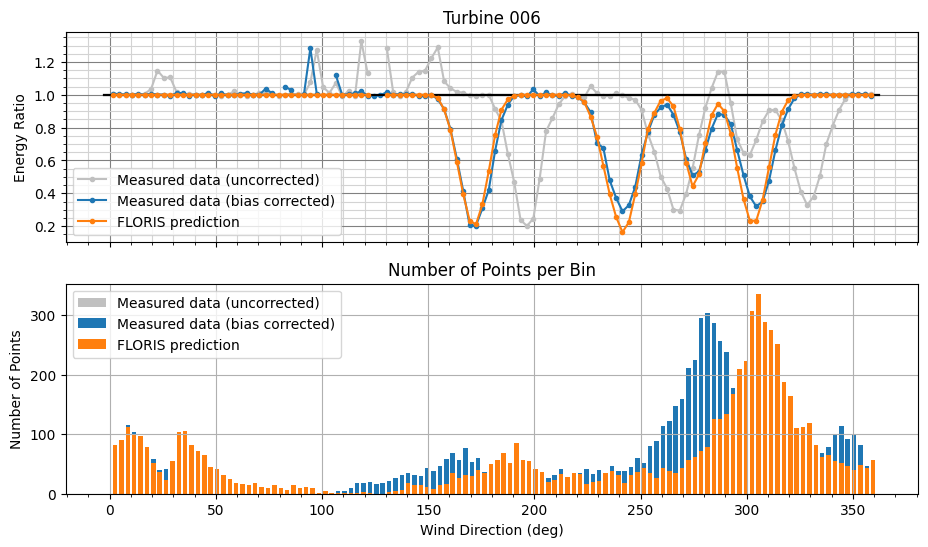

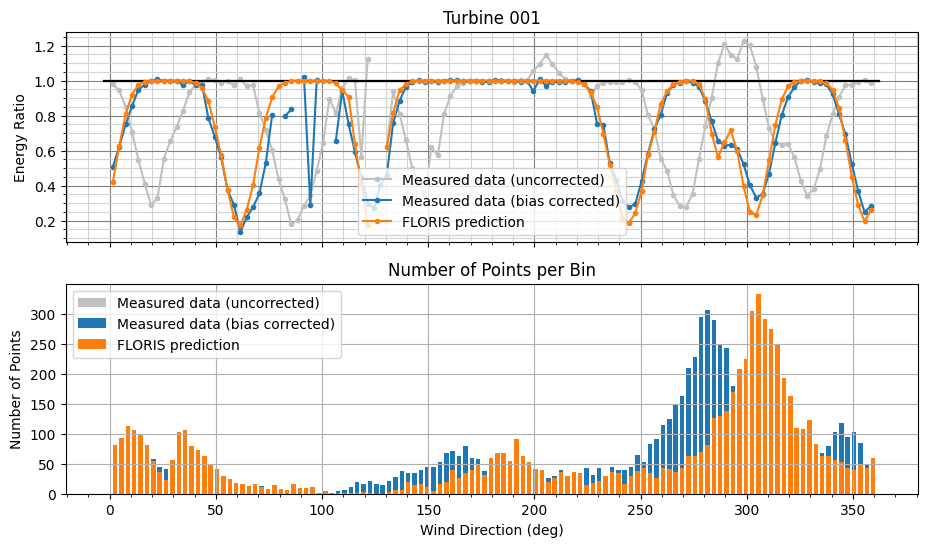

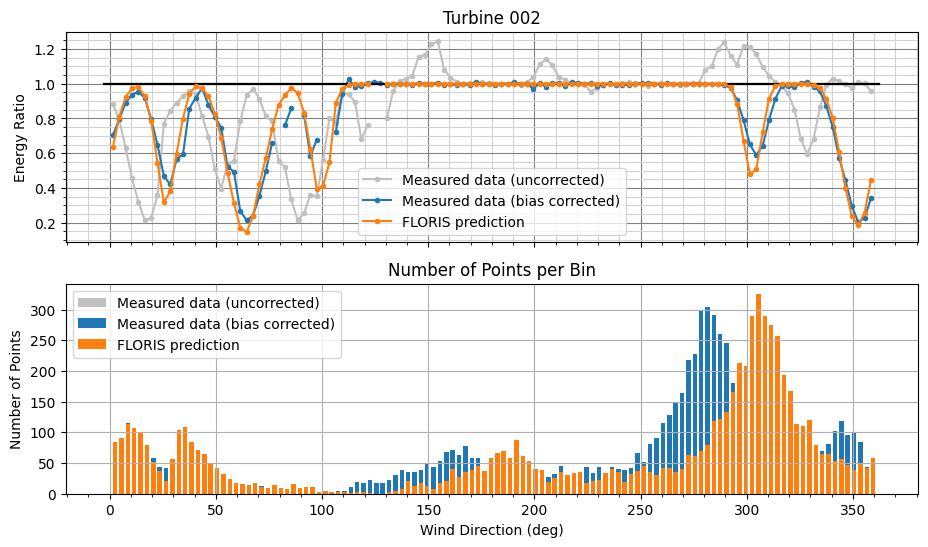

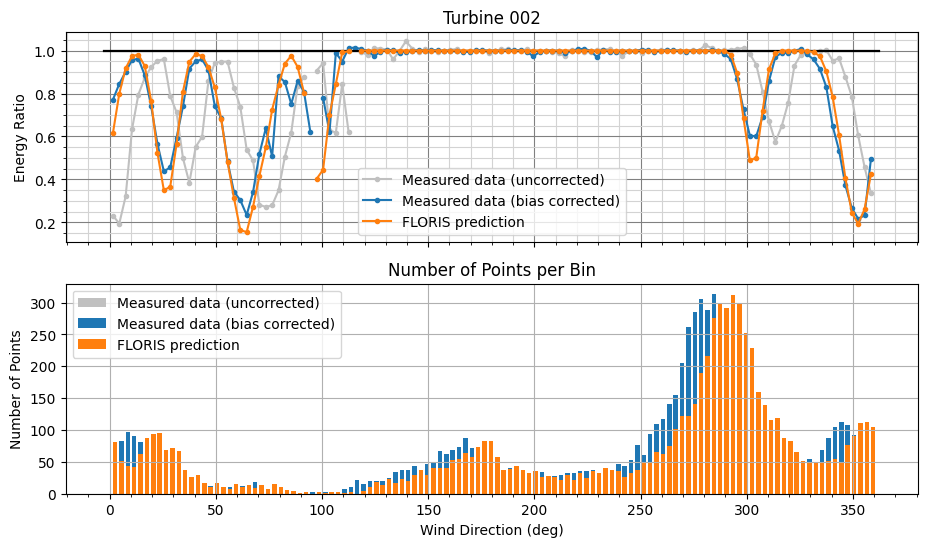

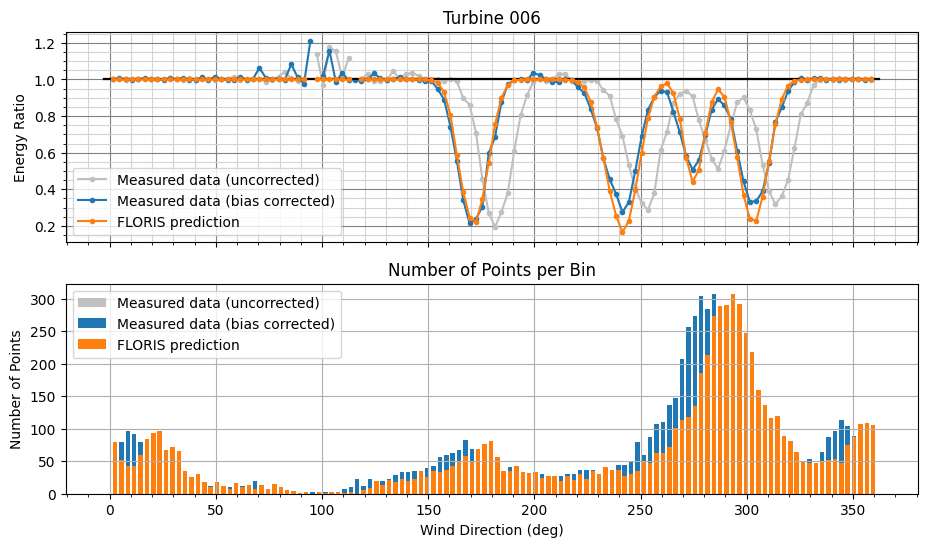

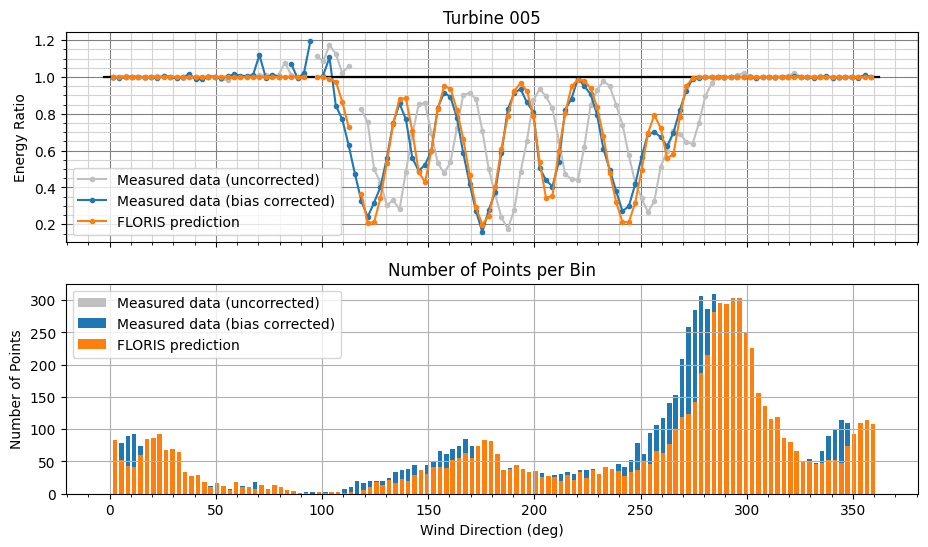

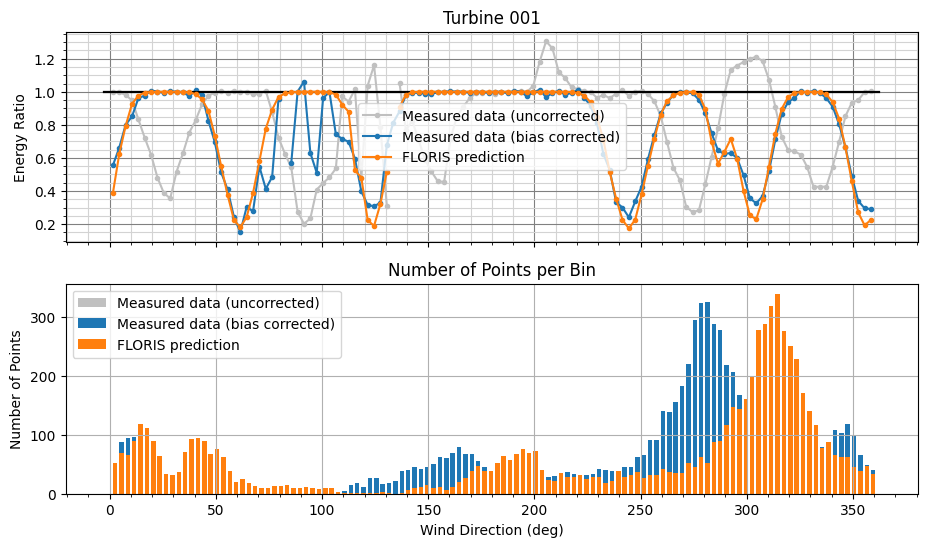

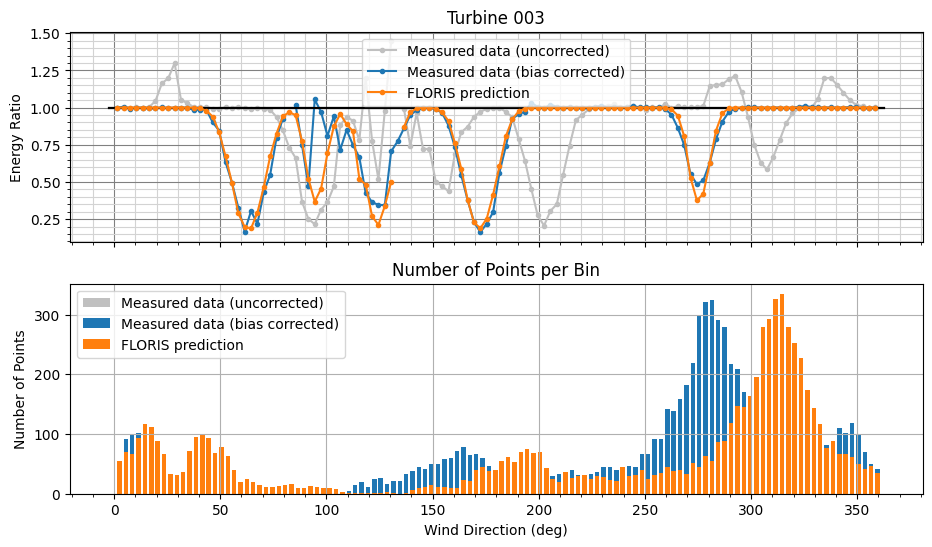

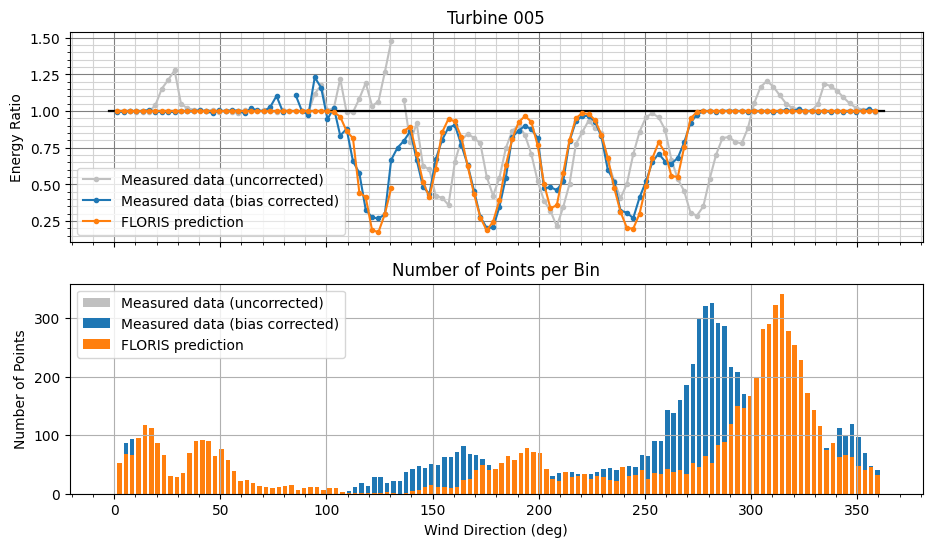

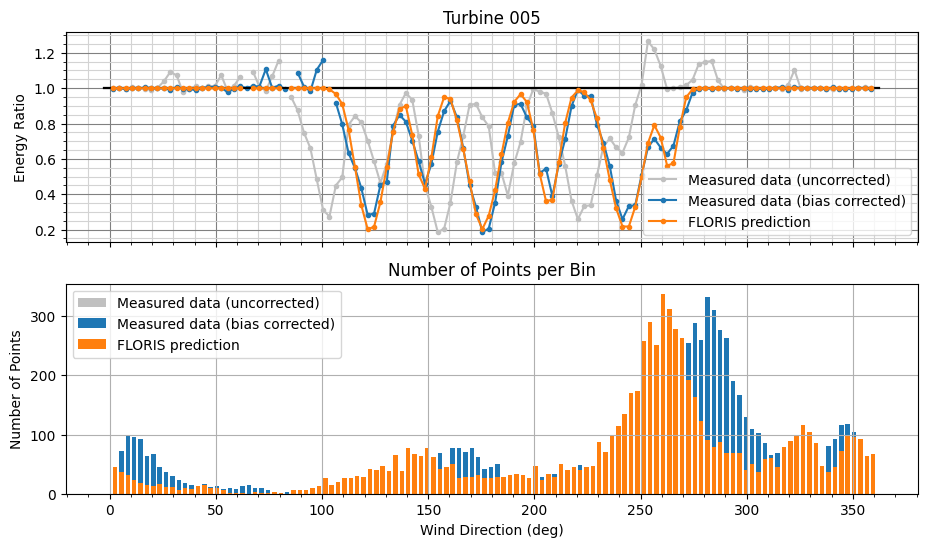

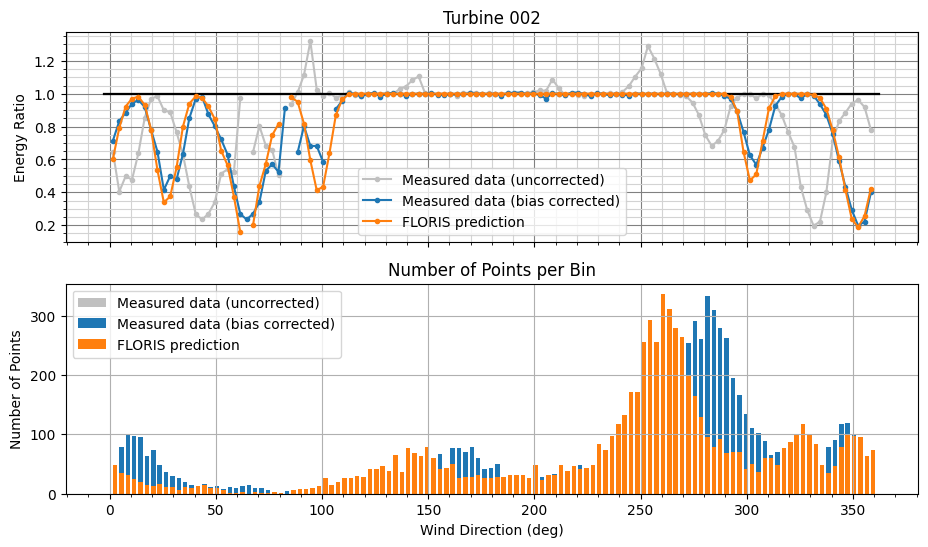

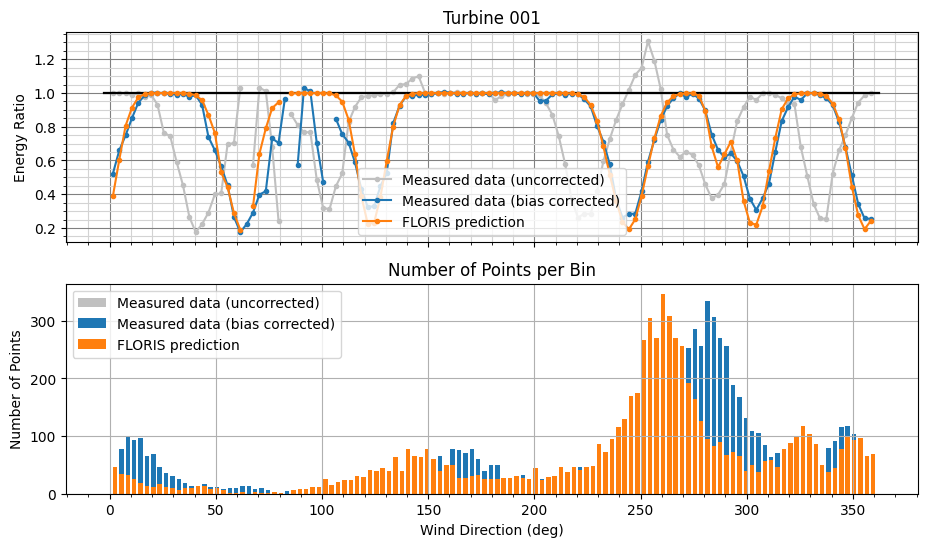

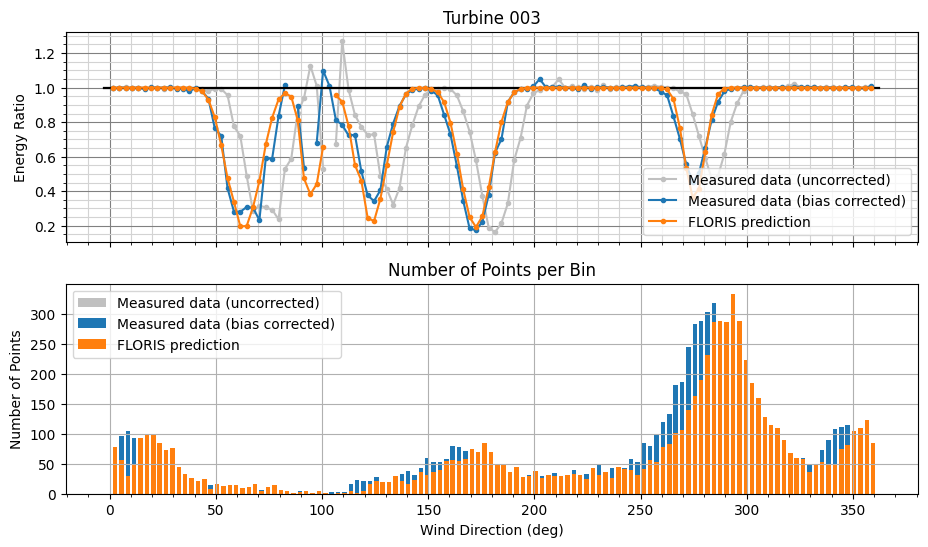

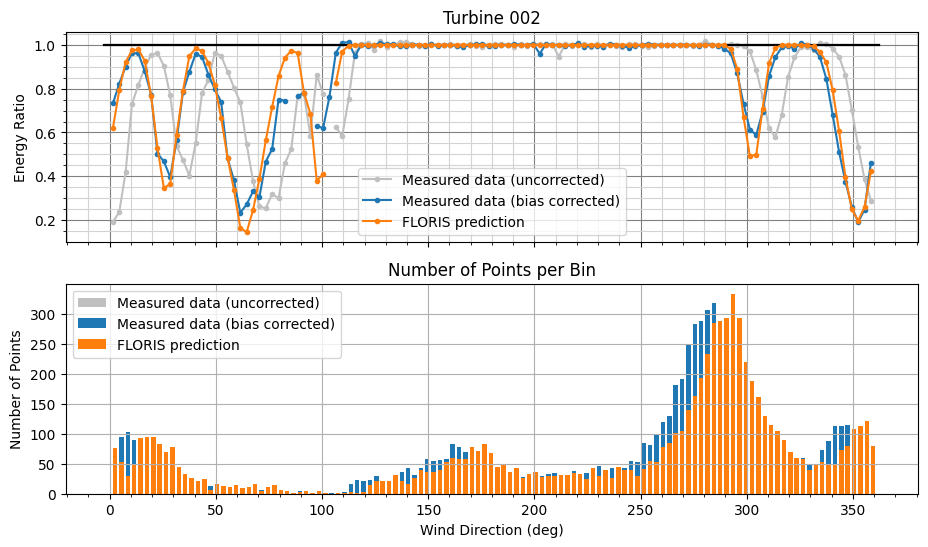

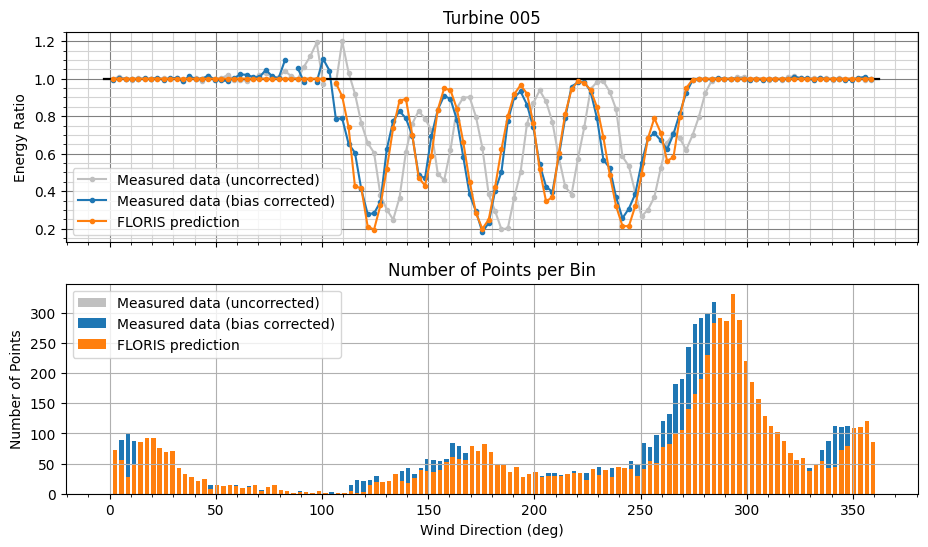

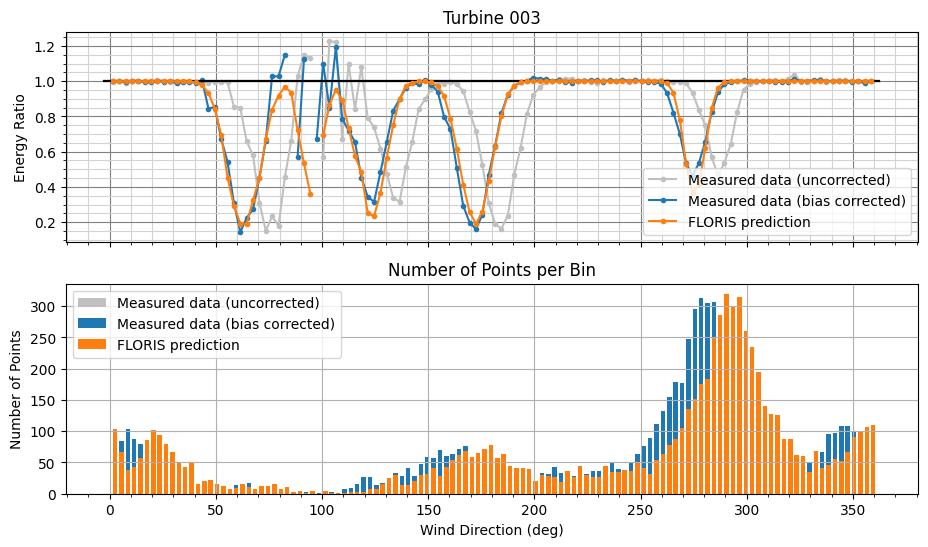

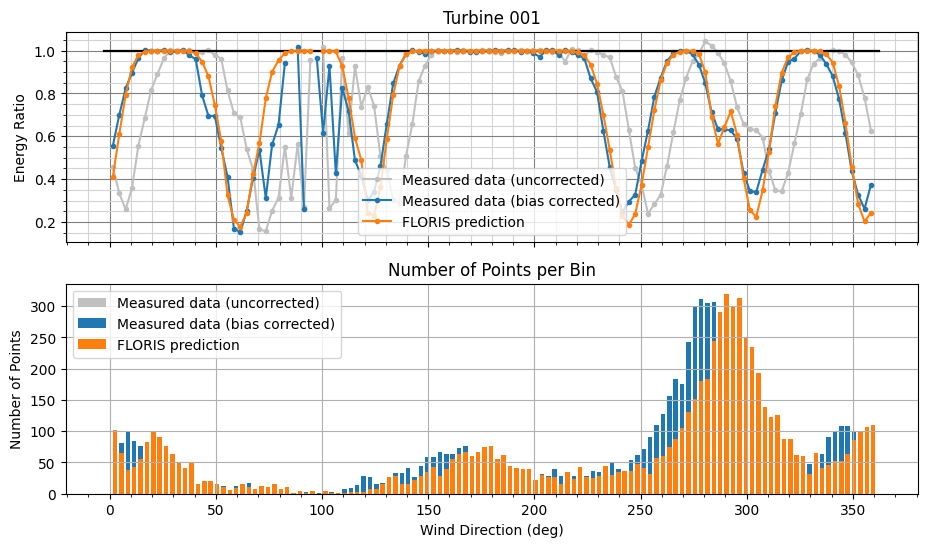

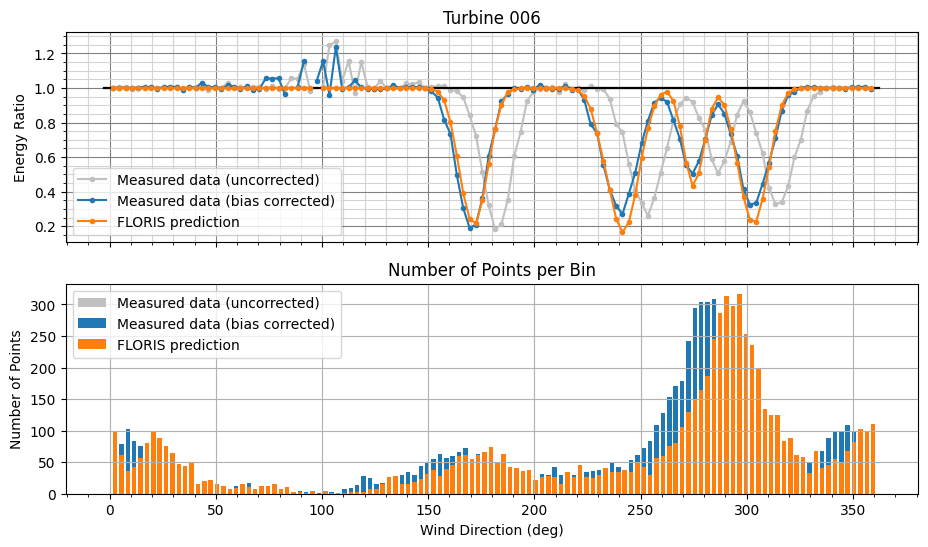

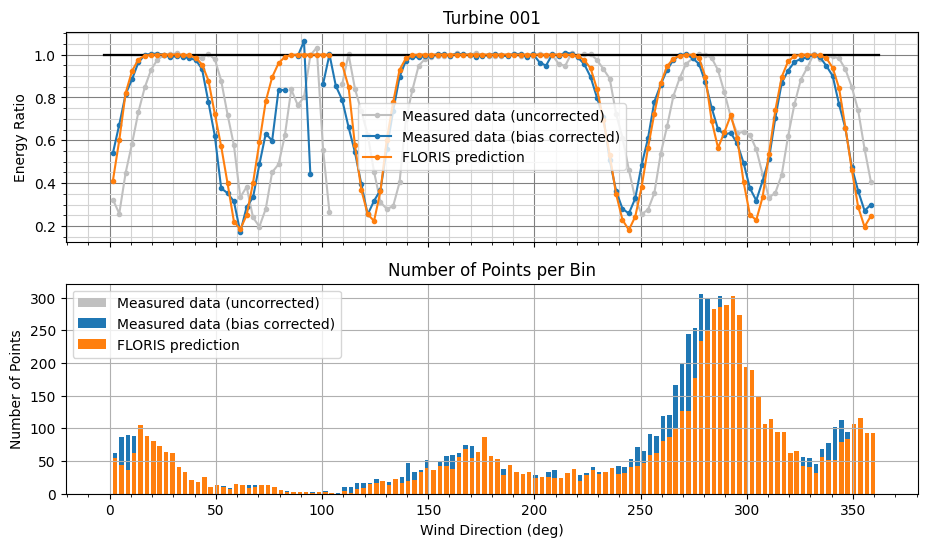

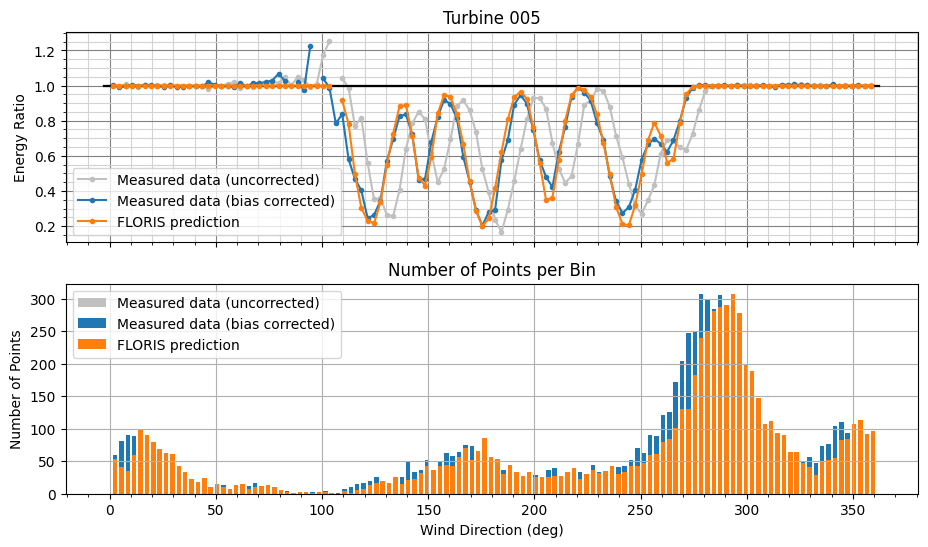

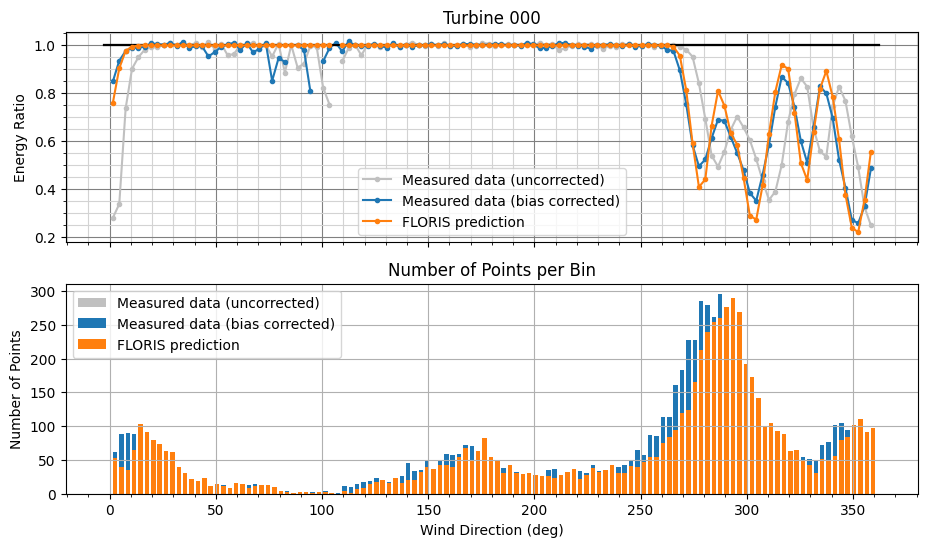

In [7]:
def estimate_biases_with_reference_wd(df_scada, fm, wd_ref):
    # Now use this knowledge to estimate bias for every turbine
    num_turbines = len(fm.layout_x)
    wd_bias_list = np.zeros(num_turbines)

    for ti in range(num_turbines):
        # Calculate the offset between this turbine's wind direction and that
        # of the calibrated (reference) wind direction. Note that 'wd_ref' may
        # also be a met mast' wind direction signal, if available. The offset
        # between a turbine's wind direction and wd_ref is very likely to be
        # the bias or close to the bias in this turbine's northing.
        wd_test = df_scada["wd_{:03d}".format(ti)]
        x0, _ = flopt.match_y_curves_by_offset(
            wd_ref, wd_test, dy_eval=np.arange(-180.0, 180.0, 2.0), angle_wrapping=True
        )

        # Then, we refine this first guess by evaluating the cost function
        # at [-5.0, 0.0, 5.0] deg around x0, and let the optimizer
        # converge.
        x_search_bounds = np.round(x0) + np.array([-5.0, 5.0])

        # Calculate and save the results to a list
        wd_bias_list[ti] = get_bias_for_single_turbine(
            df=df_scada,
            fm=fm,
            ti=ti,
            opt_search_range=x_search_bounds,
            plot=True,
            figure_save_path=None,
        )
        print(" ")

    return wd_bias_list


wd_bias_list = estimate_biases_with_reference_wd(df_scada_marked_faulty_northing_drift, fm, wd_ref)
print("Wind direction biases: {}".format(wd_bias_list))

# **Step 5**: Correct turbine wind directions for bias
The next step is to apply the northing corrections directly on the data.

In [8]:
def apply_bias_corrections(df_scada, wd_bias_list):
    # Copy dataframe
    df_out = df_scada.copy()

    # Load the SCADA data
    num_turbines = dfm.get_num_turbines(df_scada)

    # Set turbine-individual bias corrections
    for ti in range(num_turbines):
        bias = wd_bias_list[ti]
        print("Removing {:.2f} deg bias for ti = {:03d}.".format(bias, ti))
        df_out["wd_{:03d}".format(ti)] = wrap_360(df_out["wd_{:03d}".format(ti)] - bias)

    return df_out


# Get bias corrections
print("wd_bias_list: {}".format(wd_bias_list))
df_scada_northing_calibrated = apply_bias_corrections(
    df_scada=df_scada_marked_faulty_northing_drift.copy(), wd_bias_list=wd_bias_list
)

wd_bias_list: [ 24.7    10.8    31.2   -21.      9.375  12.15    7.8  ]
Removing 24.70 deg bias for ti = 000.
Removing 10.80 deg bias for ti = 001.
Removing 31.20 deg bias for ti = 002.
Removing -21.00 deg bias for ti = 003.
Removing 9.38 deg bias for ti = 004.
Removing 12.15 deg bias for ti = 005.
Removing 7.80 deg bias for ti = 006.


# **Step 6**: Deal with inter-turbine faults
Deal with faults at one turbine causing issues at another turbine. For example, if a turbine is shedding a wake on a second turbine, then for a fair comparison both of these two turbines should be operating normally. If the upstream turbine is curtailed or offline, the power production of the downstream turbine also changes. Hence, if we are unsure about the operating mode of one machine, we cannot make accurate FLORIS predictions on the second turbine either. In this scenario, we would classify the second turbine's measurement as faulty too, because of this.

In [9]:
def filter_for_faults_in_impacting_turbines(df):
    # Determine which turbines impact which other turbines through their wakes
    print("Calculating the 'df_impacting_turbines' matrix...")
    df_impacting_turbines = ftools.get_all_impacting_turbines(
        fm_in=fm,
        wd_array=np.arange(0.0, 360.0, 3.0),
        change_threshold=0.005,
        ws_test=9.0,
    )
    print(df_impacting_turbines)

    # Filter the measurements for each turbine: make sure all
    # other turbines affecting this turbine's
    # power production are marked as good measurements. If they are not,
    # then classify this turbine's
    # measurement as faulty too.
    num_turbines = dfm.get_num_turbines(df)
    for ti in range(num_turbines):
        # Assign a reference wind direction for this turbine. In this case,
        # we have such a small farm so we assume that the farm average wind
        # direction of representative of every turbine.
        df = dfm.set_wd_by_all_turbines(df)

        df_scada = dff.filter_df_by_faulty_impacting_turbines(
            df=df,
            ti=ti,
            df_impacting_turbines=df_impacting_turbines,
            verbose=True,
        )

    return df_scada


df_scada_northing_calibrated_interturbine_filtered = filter_for_faults_in_impacting_turbines(
    df=df_scada_northing_calibrated.copy()
)

Calculating the 'df_impacting_turbines' matrix...


floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.


            0    1       2   3   4   5   6
wd                                        
0.0       [6]  [5]     [3]  []  []  []  []
3.0       [6]  [5]     [3]  []  []  []  []
6.0       [6]  [5]     [3]  []  []  []  []
9.0       [6]  [5]     [3]  []  []  []  []
12.0       []  [5]     [3]  []  []  []  []
...       ...  ...     ...  ..  ..  ..  ..
345.0  [6, 5]  [5]     [3]  []  []  []  []
348.0  [6, 5]  [5]  [3, 5]  []  []  []  []
351.0     [6]  [5]     [3]  []  []  []  []
354.0     [6]  [5]     [3]  []  []  []  []
357.0     [6]  [5]  [3, 5]  []  []  []  []

[120 rows x 7 columns]
Faulty measurements for WTG 00 increased from 6.463 % to 10.196 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
Faulty measurements for WTG 01 increased from 4.816 % to 8.203 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
Faulty measurements for WTG 02 increased from 5.349 % to 7.387 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
Faulty measurements for WTG 03 increased fro

# **Step 7**: Save the processed data
We save the bias-corrected dataframe to our local path folder for then to use in further data analysis, e.g., model validation, wake loss estimation, turbine monitoring.

In [10]:
# Save the dataframe with corrected wind directions
print("Saving dataframes as .ftr files")
fout = os.path.join(
    root_path, "postprocessed", "df_scada_data_600s_filtered_and_northing_calibrated.ftr"
)
df_scada_northing_calibrated_interturbine_filtered.to_feather(fout)
print("Finished processing. Saved the df as '{:s}'.".format(os.path.relpath(fout)))

Saving dataframes as .ftr files
Finished processing. Saved the df as 'postprocessed/df_scada_data_600s_filtered_and_northing_calibrated.ftr'.


In [11]:
# Print all (remaining) figures
plt.show()